Let's use MMDetection to train with fruits [dataset](https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
!nvidia-smi

Wed Apr  6 13:15:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.3 MB/s eta 0:15:55tcmalloc: large alloc 1147494400 bytes == 0x55951da3e000 @  0x7f77053a7615 0x5594e47c617c 0x5594e48a647a 0x5594e47c8f9d 0x5594e48bad4d 0x5594e483cec8 0x5594e4837a2e 0x5594e47ca88a 0x5594e483cd30 0x5594e4837a2e 0x5594e47ca88a 0x5594e4839719 0x5594e48bbb76 0x5594e4838d95 0x5594e48bbb76 0x5594e4838d95 0x5594e48bbb76 0x5594e4838d95 0x5594e47cace9 0x5594e480e579 0x5594e47c9902 0x5594e483cc4d 0x5594e4837a2e 0x5594e47ca88a 0x5594e4839719 0x5594e4837a2e 0x5594e47ca88a 0x5594e48388f6 0x5594e47ca7aa 0x5594e4838b4f 0x5594e4837a2e
     |████████████████▌               | 1055.7 MB 1.3 MB/s eta 0:12:27tcmalloc: large alloc 1434370048 bytes == 0x559562094000 @  0x7f77053a7615 0x5594e47c617c 0x5594e48a647a 0x5594e47c8f9d 0x5594e48bad4d 0x5594e483cec8 0x5594e4837a2e 0x5594e47ca88a 0x5594e483cd30 0x5594e4837a2e 0x5594e47ca88a 0x5594e4839719 0x5594e48bbb76 0x5594e4838d

In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.23.0
11.1
GCC 7.3


In [6]:
!mkdir checkpoints
# !wget -c http://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20200307-a92d2092.pth \
!wget -c https://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20210803_015428-d231a06e.pth \
      -O checkpoints/ssd300_coco_20210803_015428-d231a06e.pth

--2022-04-06 13:19:29--  https://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20210803_015428-d231a06e.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137242646 (131M) [application/octet-stream]
Saving to: ‘checkpoints/ssd300_coco_20210803_015428-d231a06e.pth’

checkpoints/ssd300_ 100%[===================>] 130.88M  8.09MB/s    in 16s     

2022-04-06 13:19:46 (7.94 MB/s) - ‘checkpoints/ssd300_coco_20210803_015428-d231a06e.pth’ saved [137242646/137242646]



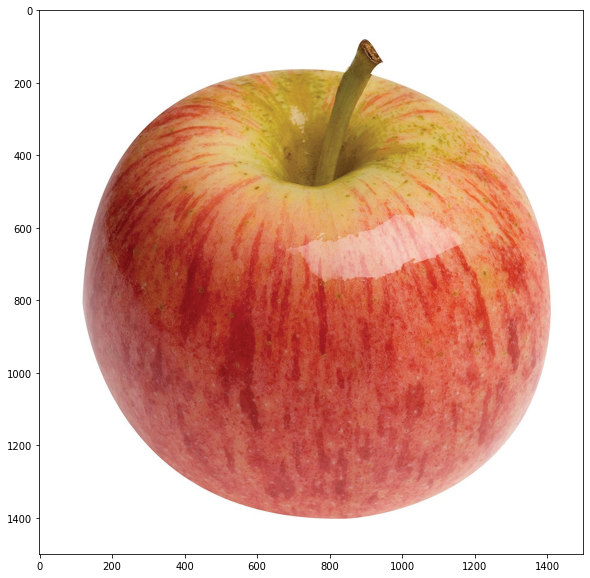

In [7]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/content/drive/MyDrive/DLS/Проект_по_курсу/training/image_2/apple_10.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Creating annotation files.

In [8]:
import os

train_list = []

with os.scandir('/content/drive/MyDrive/training/images/train_zip/train') as entries:
    for entry in entries:
        train_list.append(os.path.splitext(entry.name)[0])

train_list=set(train_list)

with open('/content/drive/MyDrive/training/images/train.txt', 'w') as f:
    for word in train_list:
        f.write(word)
        f.write('\n')

In [9]:
test_list = []

with os.scandir('/content/drive/MyDrive/training/images/test_zip/test') as entries:
    for entry in entries:
        test_list.append(os.path.splitext(entry.name)[0])
        
test_list=set(test_list)

with open('/content/drive/MyDrive/training/images/test.txt', 'w') as f:
    for word in test_list:
        f.write(word)
        f.write('\n')

In [10]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

import xml.etree.ElementTree as ET

@DATASETS.register_module(force=True)
class FruitsDataset(CustomDataset):

    CLASSES = ('apple', 'banana', 'orange')

    def load_annotations(self, ann_file):
        self.cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            
            xml_filename = f'{self.img_prefix}/{image_id}.xml'
            
            tree = ET.parse(xml_filename)
            root = tree.getroot()

            bboxes = []
            labels = []
            bboxes_ignore = []
            labels_ignore = []
            for obj in root.findall('object'):
                name = obj.find('name').text
                if name not in self.CLASSES:
                    continue
                label = self.cat2label[name]
                difficult = obj.find('difficult')
                difficult = 0 if difficult is None else int(difficult.text)
                bnd_box = obj.find('bndbox')
                # TODO: check whether it is necessary to use int
                # Coordinates may be float type
                bbox = [
                    int(float(bnd_box.find('xmin').text)),
                    int(float(bnd_box.find('ymin').text)),
                    int(float(bnd_box.find('xmax').text)),
                    int(float(bnd_box.find('ymax').text))
                ]
                ignore = False
                
                if difficult or ignore:
                    bboxes_ignore.append(bbox)
                    labels_ignore.append(label)
                else:
                    bboxes.append(bbox)
                    labels.append(label)
            if not bboxes:
                bboxes = np.zeros((0, 4))
                labels = np.zeros((0, ))
            else:
                bboxes = np.array(bboxes, ndmin=2) - 1
                labels = np.array(labels)
            if not bboxes_ignore:
                bboxes_ignore = np.zeros((0, 4))
                labels_ignore = np.zeros((0, ))
            else:
                bboxes_ignore = np.array(bboxes_ignore, ndmin=2) - 1
                labels_ignore = np.array(labels_ignore)

            data_anno = dict(
                bboxes=bboxes.astype(np.float32),
                labels=labels.astype(np.int64),
                bboxes_ignore=bboxes_ignore.astype(np.float32),
                labels_ignore=labels_ignore.astype(np.int64))
            
            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos           

In [11]:
from mmcv import Config
model_type = "ssd"

if model_type == "ssd":
    cfg = Config.fromfile('./configs/ssd/ssd300_coco.py')

In [12]:
cfg["data"]

{'samples_per_gpu': 8,
 'test': {'ann_file': 'data/coco/annotations/instances_val2017.json',
  'img_prefix': 'data/coco/val2017/',
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'flip': False,
    'img_scale': (300, 300),
    'transforms': [{'keep_ratio': False, 'type': 'Resize'},
     {'mean': [123.675, 116.28, 103.53],
      'std': [1, 1, 1],
      'to_rgb': True,
      'type': 'Normalize'},
     {'keys': ['img'], 'type': 'ImageToTensor'},
     {'keys': ['img'], 'type': 'Collect'}],
    'type': 'MultiScaleFlipAug'}],
  'type': 'CocoDataset'},
 'train': {'dataset': {'ann_file': 'data/coco/annotations/instances_train2017.json',
   'img_prefix': 'data/coco/train2017/',
   'pipeline': [{'type': 'LoadImageFromFile'},
    {'type': 'LoadAnnotations', 'with_bbox': True},
    {'mean': [123.675, 116.28, 103.53],
     'ratio_range': (1, 4),
     'to_rgb': True,
     'type': 'Expand'},
    {'min_crop_size': 0.3,
     'min_ious': (0.1, 0.3, 0.5, 0.7, 0.9),
     'type': 'MinIoURandomCrop'},
   

In [13]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'FruitsDataset'
cfg.data_root = '/content/drive/MyDrive/training/images'

cfg.data.test.type = 'FruitsDataset'
cfg.data.test.data_root = '/content/drive/MyDrive/training/images'
cfg.data.test.ann_file = 'test.txt'
cfg.data.test.img_prefix = 'test_zip/test'


cfg.data.train.dataset.type = 'FruitsDataset'
cfg.data.train.dataset.data_root = '/content/drive/MyDrive/training/images'
cfg.data.train.dataset.ann_file = 'train.txt'
cfg.data.train.dataset.img_prefix = 'train_zip/train'
# elif model_type == "mask_rcnn":
#   cfg.data.train.type = 'KittiTinyDataset'
#   cfg.data.train.data_root = 'kitti_tiny/'
#   cfg.data.train.ann_file = 'train.txt'
#   cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'FruitsDataset'
cfg.data.val.data_root = '/content/drive/MyDrive/training/images'
cfg.data.val.ann_file = 'test.txt'
cfg.data.val.img_prefix = 'test_zip/test'


cfg.model.bbox_head.num_classes = 3
cfg.load_from = 'checkpoints/ssd300_coco_20210803_015428-d231a06e.pth'
# elif model_type == "mask_rcnn":
#   cfg.model.roi_head.bbox_head.num_classes = 3
#   cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# ssd300_coco and ssd300_voc with 4gpu, 24 imgs per gpu and lr of 3e-3
cfg.optimizer.lr = 0.02 / 8.  # 3e-3
# cfg.lr_config.warmup = None
cfg.lr_config.policy = 'step'
cfg.lr_config.warmup = 'linear'
cfg.lr_config.warmup_ratio = 1.0 / 1e10

cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
input_size = 300
model = dict(
    type='SingleStageDetector',
    backbone=dict(
        type='SSDVGG',
        depth=16,
        with_last_pool=False,
        ceil_mode=True,
        out_indices=(3, 4),
        out_feature_indices=(22, 34),
        init_cfg=dict(
            type='Pretrained', checkpoint='open-mmlab://vgg16_caffe')),
    neck=dict(
        type='SSDNeck',
        in_channels=(512, 1024),
        out_channels=(512, 1024, 512, 256, 256, 256),
        level_strides=(2, 2, 1, 1),
        level_paddings=(1, 1, 0, 0),
        l2_norm_scale=20),
    bbox_head=dict(
        type='SSDHead',
        in_channels=(512, 1024, 512, 256, 256, 256),
        num_classes=3,
        anchor_generator=dict(
            type='SSDAnchorGenerator',
            scale_major=False,
            input_size=300,
            basesize_ratio_range=(0.15, 0.9),
            strides=[8, 16, 32, 64, 100, 300],
            ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]]),
        bbox_coder=dict(


In [14]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector( cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection/mmdet/datasets/custom.py:180: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-04-06 13:20:45,728 - mmdet - INFO - load checkpoint from local path: checkpoints/ssd300_coco_20210803_015428-d231a06e.pth
2022-04-06 13:20:45,868 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.cls_convs.0.0.weight: copying a param with shape torch.Size([324, 512, 3, 3]) from checkpoint, the shape i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 60/60, 28.6 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-06 13:34:53,425 - mmdet - INFO - 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| apple  | 35  | 225  | 0.971  | 0.900 |
| banana | 40  | 214  | 0.925  | 0.824 |
| orange | 42  | 287  | 1.000  | 0.928 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.884 |
+--------+-----+------+--------+-------+
2022-04-06 13:34:53,428 - mmdet - INFO - Epoch(val) [12][60]	AP50: 0.8840, mAP: 0.8840
2022-04-06 13:35:00,824 - mmdet - INFO - Epoch [13][10/151]	lr: 2.500e-03, eta: 0:13:55, time: 0.718, data_time: 0.297, memory: 1608, loss_cls: 1.2793, loss_bbox: 0.5581, loss: 1.8373
2022-04-06 13:35:05,229 - mmdet - INFO - Epoch [13][20/151]	lr: 2.500e-03, eta: 0:13:50, time: 0.441, data_time: 0.034, memory: 1608, loss_cls: 1.2955, loss_bbox: 0.4665, loss: 1.7620
2022-04-06 13:35:09,745 - mmdet - INFO - Epoch [13][30/151]	lr: 2.500e-03, eta: 0:13:45, time: 0.451, data_time: 0.038, memory: 1608, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 60/60, 29.2 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-06 13:49:05,756 - mmdet - INFO - 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| apple  | 35  | 155  | 0.971  | 0.926 |
| banana | 40  | 67   | 0.775  | 0.745 |
| orange | 42  | 72   | 0.976  | 0.943 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.871 |
+--------+-----+------+--------+-------+
2022-04-06 13:49:05,760 - mmdet - INFO - Epoch(val) [24][60]	AP50: 0.8710, mAP: 0.8713


/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


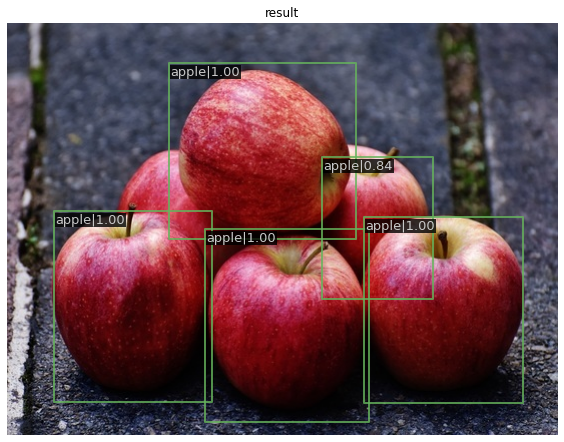

In [15]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
img = mmcv.imread('/content/drive/MyDrive/training/images/apple.jpg')


model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [18]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DLS/Проект_по_курсу/ssd_weights.pth')